In [1]:
from __future__ import print_function

import sys

sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm

from datetime import datetime
from pytz import timezone
import copy

import numpy as np
import torch

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from in_out.detector.detector_dataset import RegionDetectorDataSet
from config.config import config
from common.detector.config import config_detector
from plotting.color_maps import transparent_cmap
from utils.exper_hdl_ensemble import ExperHandlerEnsemble
from common.dslices.config import config
from common.detector.box_utils import find_bbox_object, BoundingBox
from utils.detector.batch_handler import BatchHandler
from utils.detector.experiment import Experiment
from utils.detector.exper_handler import ExperimentHandler

mycmap = transparent_cmap(plt.get_cmap('jet'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"

# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Load our baseline 
seg_exper_ensemble = ExperHandlerEnsemble(config.exper_dict_brier)

Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['0'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['1'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['2'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['3'] loss=brier


In [3]:
from in_out.detector.detector_dataset import create_dataset

dataset = create_dataset(seg_exper_ensemble, train_fold_id=0, quick_run=False, num_of_input_chnls=3)

INFO - Preparing experimental handlers. This may take a while. Be patient...
INFO - Ready. Loop through patient ids.


100%|██████████| 100/100 [00:26<00:00,  3.82it/s]


In [6]:
roi_stats = dataset.roi_stats["train"]
print(roi_stats)
print("Perc of positives {:.5f}".format(float(roi_stats[1])/roi_stats[0]))

[1359330    1130     409     721]
Perc of positives 0.00083


In [87]:
batch_size = 8
new_batch = BatchHandler(dataset, is_train=False, cuda=True, keep_bounding_boxes=False, verbose=False)


In [89]:
for batch_imgs, target_labels_per_roi in new_batch(batch_size=8, keep_batch=True):
    print(new_batch.current_slice_ids)


[8]
[8, 9]
[8, 9, 10]
[8, 9, 10, 11]
[8, 9, 10, 11, 12]
[8, 9, 10, 11, 12, 13]
[8, 9, 10, 11, 12, 13, 14]
[8, 9, 10, 11, 12, 13, 14, 15]


In [ ]:
idx = None
for s in np.arange(len(dataset.test_labels)):
    img = dataset.test_labels[s]
    if 0 != np.count_nonzero(img):
        idx = s
    
        if idx > 25:
            break
    
idx = 133
test_img = dataset.test_images[idx]
test_lbl = dataset.test_labels[idx]
test_pred_roi = dataset.test_pred_lbl_rois[idx]
print(test_img.shape, test_lbl.shape)
print(test_pred_roi)

fig = plt.figure(figsize=(56, 50))
ax1 = plt.subplot2grid((2, 4), (0, 0), rowspan=2, colspan=2)
ax1.imshow(test_img[0], cmap=cm.gray)
ax1.imshow(test_img[2], cmap=mycmap)
# ax1.imshow(test_lbl, cmap=mycmap)
# ax1.imshow(test_img[1], cmap=mycmap)
roi_box = BoundingBox.create(test_pred_roi, padding=0)
print(roi_box.width, roi_box.height)
ax1.add_patch(roi_box.get_matplotlib_patch(color='b'))

plt.axis("off")
plt.show()
# ax2 = plt.subplot2grid((2, 4), (0, 2), rowspan=2, colspan=2)
# ax2.imshow(test_lbl, cmap=cm.gray)
# plt.axis("off")

[ 150.   74.  222.  146.]


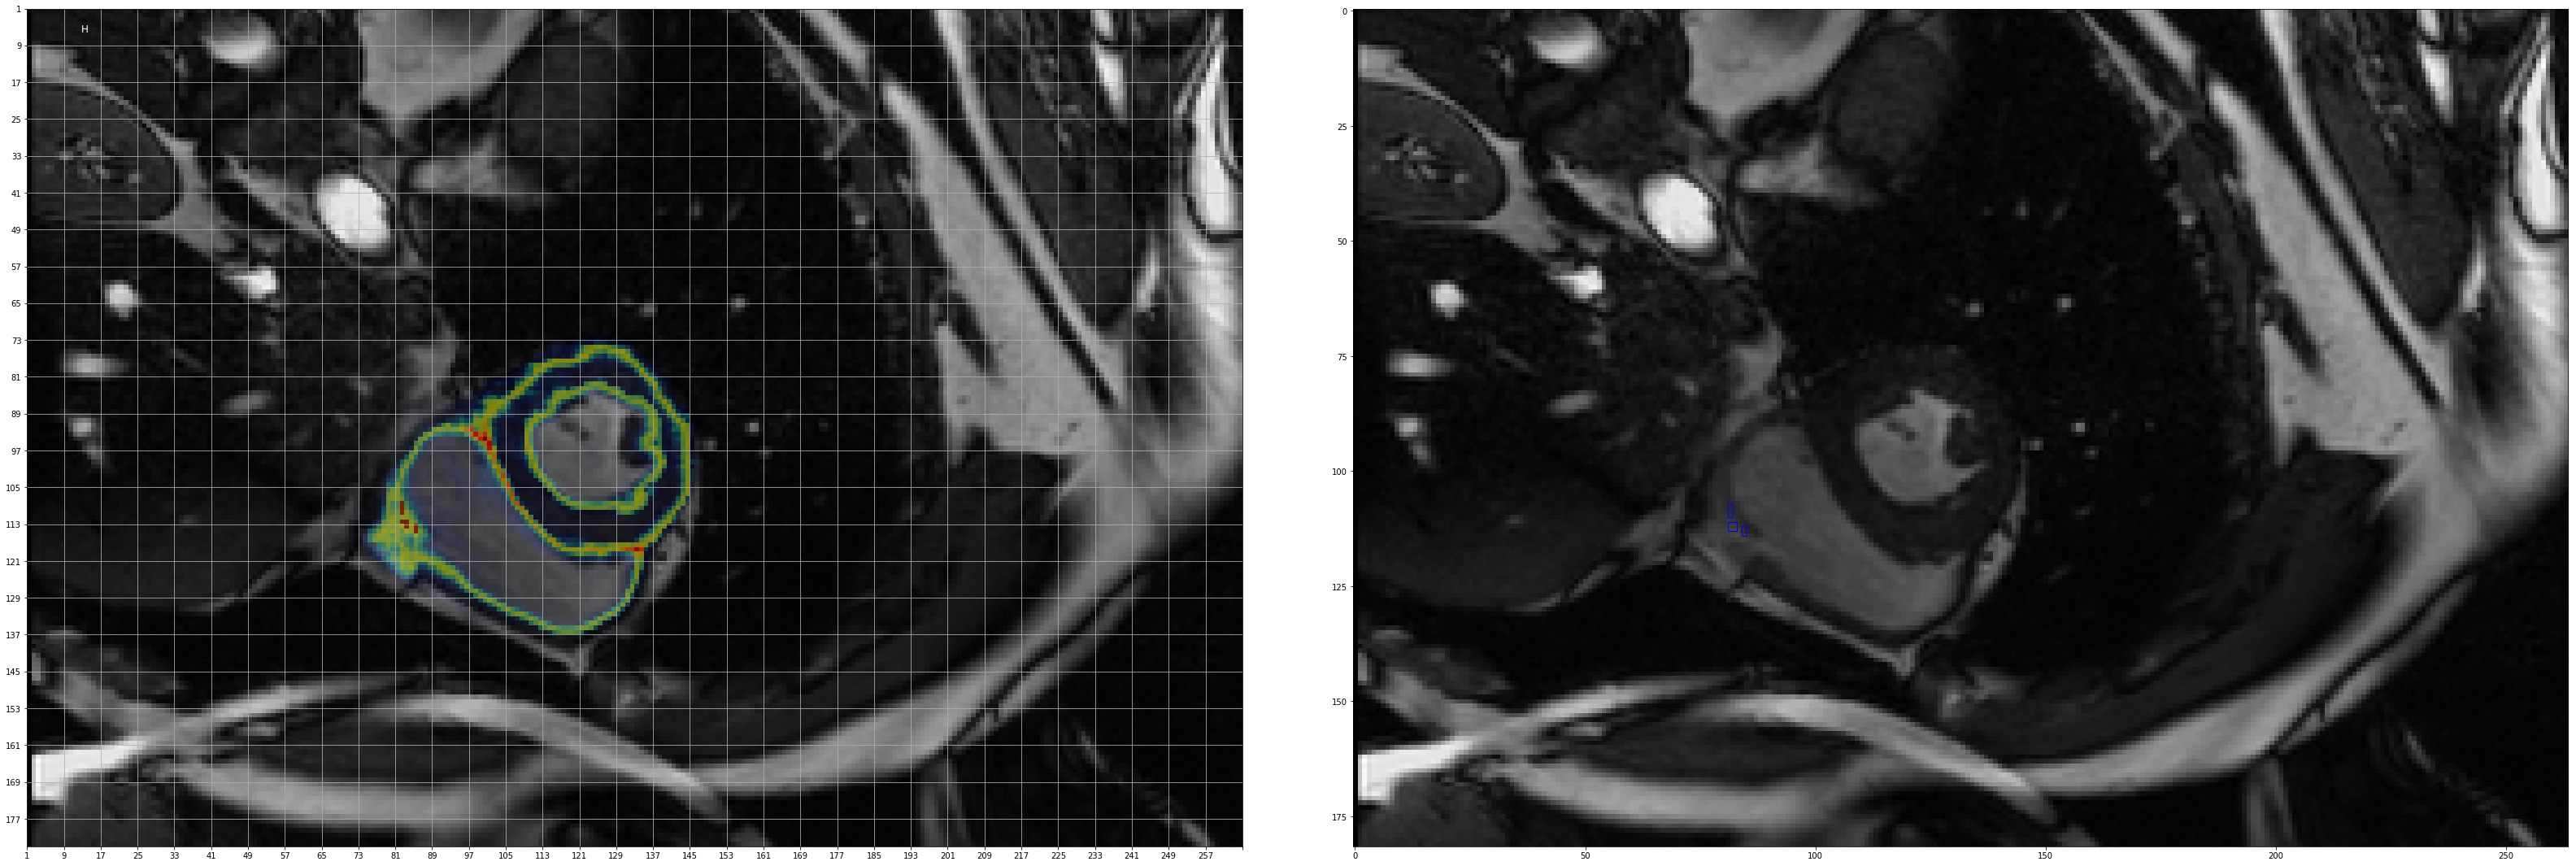

In [68]:
slice_num = 197
batch_nr = 1
image = dataset.train_images[slice_num]
label = dataset.train_labels[slice_num]
bbox = new_batch.batch_bounding_boxes[batch_nr]
bbox = BoundingBox.create(bbox)
print(bbox.box_four)
fig = plt.figure(figsize=(56, 50))

ax1 = plt.subplot2grid((2, 4), (0, 0), rowspan=2, colspan=2)
w, h = image[0].shape
ax1.imshow(image[0], cmap=cm.gray)
ax1.imshow(image[1], cmap=mycmap)
ax1.imshow(label, cmap=mycmap)

ax1.grid(which='minor', color='w', linestyle='-', linewidth=4)
ax1.set_xticks(np.arange(-.5, h, 8))
ax1.set_yticks(np.arange(-.5, w, 8))
ax1.set_xticklabels(np.arange(1, h+1, 8))
ax1.set_yticklabels(np.arange(1, w+1, 8))
ax1.text(12, 4, 'H', size='large',
            ha='center', va='center', color='w')
plt.grid(True)
# ax1.add_patch(bbox.get_matplotlib_patch(color='b'))
ax2 = plt.subplot2grid((2, 4), (0, 2), rowspan=2, colspan=2)
ax2.imshow(image[0], cmap=cm.gray)

for roi_idx in np.arange(dataset.train_lbl_rois[slice_num].shape[0]):
    box_four = dataset.train_lbl_rois[slice_num][roi_idx]
    roi_box = BoundingBox.create(box_four)
    ax2.add_patch(roi_box.get_matplotlib_patch(color='b'))

# ax1.imshow(center_mask, cmap=mycmap)
plt.show()

In [9]:
batch_size = 8
new_batch = BatchHandler(dataset, is_train=True, cuda=True, keep_bounding_boxes=True, verbose=False,
                         num_of_max_pool_layers=4)
batch_imgs, _target_labels_per_roi = new_batch(batch_size=batch_size)
print(new_batch.dataset_slice_ids)

[2733, 593, 453, 2758, 5144, 2864, 2340, 3337]


In [20]:
target_labels = new_batch.target_labels_per_roi
# this is a dict with keys 1, 4, 8
print(np.where(target_labels[8][0] !=0 ))

(array([20, 21, 29, 30, 40, 41, 42, 47, 48, 49, 50, 51, 56, 57, 58, 59, 65,
       66, 67, 68]),)


number_of_slices 30 height, width 240, 16


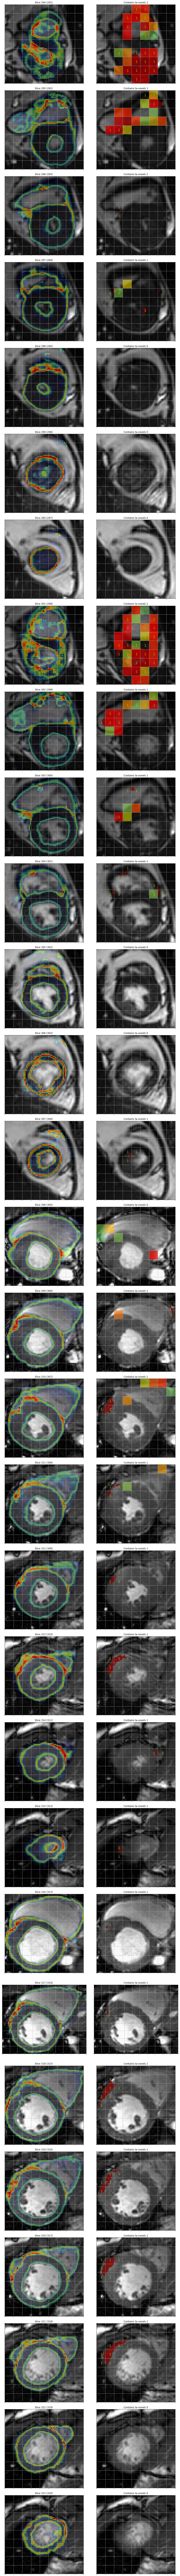

In [26]:
eval_batch.visualize_batch(grid_spacing=8, index_range=[290, 320])

In [4]:
from utils.detector.exper_handler import create_experiment

exper_id_rd2 = "20181016_11_49_37_rd2_f0p01_brier_emap_200KE_lr1e04"
exper_id_rd1 = "20181016_11_46_00_rd1_f0p01_brier_emap_200KE_lr1e04"
exper_id_rd2_bayes = "20181016_18_17_47_rd1_f0p01_brier_umap_200KE_lr1e04"
exper_id_rd3 = "20181023_12_10_48_rd3_f0_emap_brier_emap_50KE_lr1e05"

exp_handler = create_experiment(exper_id_rd3)



Load experiment from /home/jorg/repository/dcnn_acdc/logs/RD/20181023_12_10_48_rd3_f0_emap_brier_emap_50KE_lr1e05/stats/exper_stats.dll


In [5]:
rd_model = exp_handler.load_checkpoint(checkpoint=25000)

Creating new model RegionDetector: rd3-detector
INFO - RegionDetector - debug - num_of_channels_last_layer 128
INFO - RegionDetector - debug - total #parameters 140514


In [21]:
exp_handler.exper.config.get_architecture(model_name=exp_handler.exper.run_args.model)
eval_batch = exp_handler.eval(dataset, rd_model, eval_size=500, keep_batch=True, verbose=False)
eval_batch.fill_trans_dict()

('self.exper.config.num_of_max_pool ', 4)
('lbl_slice.shape ', (96, 88))
('len(label_patches) ', 132)
(8, 0, (132,))
(8, 1, (132,))
(8, 2, (132,))
(8, 3, (132,))
(8, 4, (132,))
(8, 5, (132,))
(8, 6, (132,))
(8, 7, (132,))
(8, 8, (132,))
(8, 9, (132,))
(8, 10, (132,))
(8, 11, (132,))
(8, 12, (132,))
(8, 13, (132,))
(8, 14, (132,))
(8, 15, (132,))
(8, 16, (132,))
(8, 17, (132,))
(8, 18, (132,))
(8, 19, (132,))
(8, 20, (132,))
(8, 21, (132,))
(8, 22, (132,))
(8, 23, (132,))
(8, 24, (132,))
(8, 25, (132,))
(8, 26, (132,))
(8, 27, (132,))
(8, 28, (132,))
(8, 29, (132,))
(8, 30, (132,))
(8, 31, (132,))
(8, 32, (132,))
(8, 33, (132,))
(8, 34, (132,))
(8, 35, (132,))
(8, 36, (132,))
(8, 37, (132,))
(8, 38, (132,))
(8, 39, (132,))
(8, 40, (132,))
(8, 41, (132,))
(8, 42, (132,))
(8, 43, (132,))
(8, 44, (132,))
(8, 45, (132,))
(8, 46, (132,))
(8, 47, (132,))
(8, 48, (132,))
(8, 49, (132,))
(8, 50, (132,))
(8, 51, (132,))
(8, 52, (132,))
(8, 53, (132,))
(8, 54, (132,))
(8, 55, (132,))
(8, 56, (132

IndexError: index 30 is out of bounds for axis 0 with size 30

In [13]:
patient_id = eval_batch.trans_dict[428]
print(patient_id)
print(dataset.trans_dict[patient_id])

patient097
(False, [424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439])


In [8]:
def compute_tp_tn_fn_fp(result, reference):
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
        
    tp = np.count_nonzero(result & reference)
    tp_idx = result & reference
    fn = np.count_nonzero(~result & reference)
    fn_idx = ~result & reference
    tn = np.count_nonzero(~result & ~reference)
    tn_idx = ~result & ~reference
    fp = np.count_nonzero(result & ~reference)
    fp_idx = result & ~reference
    print(np.count_nonzero(fp_idx))
    return tuple((tp, tp_idx)), tuple((fn, fn_idx)), tuple((tn, tn_idx)), tuple((fp, fp_idx))


In [31]:
from utils.dslices.accuracies import compute_eval_metrics

grid_spacing = 8
gt_labels = np.array(eval_batch.batch_gt_labels)
label_stats = np.array(eval_batch.target_labels_stats_per_roi[grid_spacing])

labels_stats_filtered_idx = np.logical_or(label_stats > 20., label_stats == 0)

pred_labels = np.array(eval_batch.batch_pred_labels)
pred_probs = eval_batch.flatten_batch_probs()

label_stats_filtered = label_stats[labels_stats_filtered_idx]
pred_labels_filtered = pred_labels[labels_stats_filtered_idx]
pred_probs_filtered = pred_probs[labels_stats_filtered_idx]
gt_labels_filtered = gt_labels[labels_stats_filtered_idx]

print(label_stats.shape, np.sum(label_stats), np.sum(label_stats_filtered), 
      np.count_nonzero(label_stats_filtered))

f1, roc_auc, pr_auc, prec, rec, fpr, tpr, precision, recall = \
            compute_eval_metrics(gt_labels_filtered, pred_labels_filtered, pred_probs_filtered)

tp_2, fn_2, tn_2, fp_2 = compute_tp_tn_fn_fp(pred_labels_filtered, gt_labels_filtered)
tp, fn, tn, fp = tp_2[0], fn_2[0], tn_2[0], fp_2[0]
print("roc_auc {:.3f} pr_auc {:.3f} Precision {:.3f} / Recall {:.3f}".format(roc_auc, pr_auc, 
                                                                             float(tp)/(tp+fp), 
                                                                             float(tp)/(tp + fn)))
tp_idx, fn_idx, tn_idx, fp_idx = tp_2[1], fn_2[1], tn_2[1], fp_2[1]

(40727,) 13738.0 9473.0 232
1645
roc_auc 0.957 pr_auc 0.541 Precision 0.100 / Recall 0.789


Total #grids=40727; #negatives=39905; #positives=822
1645
Precision 0.253 / Recall 0.678
Number of fp=1645 fn=265
Voxels all=13738.0, tp=0.75, fn=0.25
(64,) (63,) (63,) (63,)


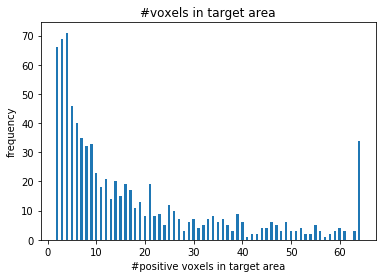

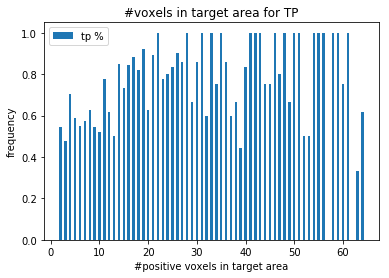

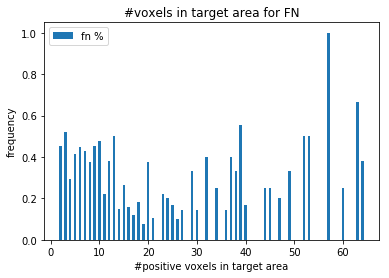

In [28]:
grid_spacing = 8
gt_labels = np.array(eval_batch.batch_gt_labels)
label_stats = np.array(eval_batch.target_labels_stats_per_roi[grid_spacing])

total_num_grids = gt_labels.shape[0]
total_positives = np.count_nonzero(label_stats != 0)
total_negatives = total_num_grids - total_positives

print("Total #grids={}; #negatives={}; #positives={}".format(total_num_grids, total_negatives, total_positives))

pred_labels = np.array(eval_batch.batch_pred_labels)
pred_probs = eval_batch.flatten_batch_probs()

tp_2, fn_2, tn_2, fp_2 = compute_tp_tn_fn_fp(pred_labels, gt_labels)
tp, fn, tn, fp = tp_2[0], fn_2[0], tn_2[0], fp_2[0]
print("Precision {:.3f} / Recall {:.3f}".format(float(tp)/(tp+fp), float(tp)/(tp + fn)))
tp_idx, fn_idx, tn_idx, fp_idx = tp_2[1], fn_2[1], tn_2[1], fp_2[1]

label_stats_tp = label_stats[tp_idx]
label_stats_fn = label_stats[fn_idx]
label_stats_fp = label_stats[fp_idx]
pred_probs_tp = pred_probs[tp_idx]
print("Number of fp={} fn={}".format(fp, fn))
num_all_voxels = np.sum(label_stats)
print("Voxels all={}, tp={:.2f}, fn={:.2f}".format(num_all_voxels, np.sum(label_stats_tp)/num_all_voxels, 
                                           np.sum(label_stats_fn)/num_all_voxels))

label_hist, bin_edges = np.histogram(label_stats, bins=np.unique(label_stats))
label_hist_fn, _ = np.histogram(label_stats_fn, bins=np.unique(label_stats))
label_hist_tp, _ = np.histogram(label_stats_tp, bins=np.unique(label_stats))

print(bin_edges.shape, label_hist.shape, label_hist_fn.shape, label_hist_tp.shape)
plt.bar(bin_edges[2:], label_hist[1:], 0.5, align='center')
plt.title("#voxels in target area")
plt.xlabel("#positive voxels in target area")
plt.ylabel("frequency")
plt.show()

tp_percs = label_hist_tp / label_hist.astype(np.float)
fn_percs = label_hist_fn / label_hist.astype(np.float)

# Note: bin_edges = [  0.   1.   2.   3 ...] Hence, we omit the first 2 entries because we're not interested
#                                            in the "negatives" i.e. the areas that don't contain positive voxels

plt.bar(bin_edges[2:], tp_percs[1:], width=0.5, align='center', label="tp %")
plt.legend(loc="best")
plt.title("#voxels in target area for TP")
plt.xlabel("#positive voxels in target area")
plt.ylabel("frequency")
plt.show()

plt.bar(bin_edges[2:], fn_percs[1:], width=0.5, align='center', label="fn %")
plt.legend(loc="best")
plt.title("#voxels in target area for FN")
plt.xlabel("#positive voxels in target area")
plt.ylabel("frequency")
plt.show()

# make plot with x-axis #voxels (as-is) and y-axis mean-softmax per bin



In [ ]:
rd1:
150000: loss 0.064: f1=0.488 - roc_auc=0.949 - pr_auc=0.517 - prec=0.606 - rec=0.408
200000: loss 0.068: f1=0.475 - roc_auc=0.947 - pr_auc=0.483 - prec=0.499 - rec=0.452
        
rd2:
150000: loss 0.102: f1=0.480 - roc_auc=0.948 - pr_auc=0.520 - prec=0.499 - rec=0.463
200000: loss 0.100: f1=0.511 - roc_auc=0.947 - pr_auc=0.527 - prec=0.533 - rec=0.490
        
rd2 with u-map distortion (random Gaussian noise)
loss 0.960: f1=0.016 - roc_auc=0.435 - pr_auc=0.018 - prec=0.011 - rec=0.027

rd2 with auto seg-mask distortion:
loss 0.886: f1=0.000 - roc_auc=0.502 - pr_auc=0.020 - prec=0.000 - rec=0.000

rd2 with image (mri) distortion:
loss 0.886: f1=0.000 - roc_auc=0.433 - pr_auc=0.017 - prec=0.000 - rec=0.000    

import SimpleITK as sitk
arr
img = sitk.GetImageFromArray(arr)
img.SetSpacing(origimg.GetSpacing())
sitk.WriteImage(fname, img)

In [66]:
from common.nms.nms_wrapper import nms